In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [79]:
# load WW data
datapath = '/home/brian/WesternWheat/Data/Processed/stripped_mini_maxseason_labeled_df_23.csv'
#datapath = '/home/brian/WesternWheat/Data/Processed/stripped_max_labeled_df_23.csv'

df = pd.read_csv(datapath)
Num_farms = pd.unique(df.pixel).size
print ('there are {} unique farms in loaded df'.format(Num_farms))
df_unique =  df.set_index('pixel')
df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index value

farm_idx = df.pixel.values.astype(int)
N_farms = pd.unique(df.pixel).size
#====================================
# reindexing pixels from 0-Nfarms
#====================================
zero_farm_idx = np.zeros_like(farm_idx)

for i,farm in enumerate((np.unique(farm_idx))):
        for j in np.where(farm_idx == farm): 
            zero_farm_idx[j] = int(i)   
            
##########################################################
# This keeps order only becuase df is sorted by farm_idx
#########################################################
df['farm'] = zero_farm_idx

there are 164 unique farms in loaded df


In [127]:
###########################
# ==== distance matrix ====
###########################

from scipy.spatial import distance_matrix
from geopy.distance import geodesic

# contrived  -- will fix with proper trigonometry later
#df_means['northish'] = (df_means.Latitude - df_means.Latitude.mean())/df_means.Latitude.std()
#df_means['westish'] = (df_means.Longitude - df_means.Longitude.mean())/df_means.Longitude.std(
#plt.scatter(df_means.westish, df_means.northish)
#plt.figure()
#plt.scatter(df_means.Longitude,df_means.Latitude)
#dfm = df_means[['northish','westish']]
#df_dist = pd.DataFrame(distance_matrix(dfm.values, dfm.values), index=dfm.index, columns=dfm.index)

def distancematrix(df, sparse=False, dlim=100):
    unique_farms = pd.unique(df.pixel)
    distance = np.zeros((unique_farms.size,unique_farms.size))
    
    df_unique = df.set_index('pixel')
    df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index values

    for i in range(unique_farms.size):
        lat_lon_i = df_unique.Latitude.iloc[i],df_unique.Longitude.iloc[i]
        for j in range(unique_farms.size):
            lat_lon_j = df_unique.Latitude.iloc[j],df_unique.Longitude.iloc[j]
            distance[i,j] = geodesic(lat_lon_i, lat_lon_j).miles
            if sparse == True and distance[i,j]>dlim:
                distance[i,j] = np.NaN
    return distance


distance = distancematrix(df, False, dlim=100)


Dmatsq = np.power(distance, 2)


In [182]:
# ==== Model I want to reparm =====
with pm.Model() as GP:
    
    # ====== covariance matrix ========
    #etasq = pm.HalfCauchy('etasq', 1) # sets maximum covariance ij
    etasq = pm.Uniform('etasq', 0,1) 
    #rhosq = pm.HalfCauchy('rhosq', 1.5e-6) # determines rate of covariance decline between farms
    rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-2
    # will have very small posterior because distances are so large in Dmatsq
    Kij = pm.Deterministic('K',etasq*(np.exp(-rhosq*Dmatsq)+np.diag([sigmay]*Num_farms)))
    

    # ========== gaussian process ===========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
    #a = np.zeros(Num_farms)
    # ========== Linear Mofdel =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    #sigma = .8
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 
    
    trace=pm.sample(1000,tune=100,chains=2)


                          

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w, rhosq, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [06:11<00:00,  3.74draws/s]
The acceptance probability does not match the target. It is 0.8958507618590222, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
pm.traceplot(trace);

KeyboardInterrupt: 

In [176]:
pm.sample?

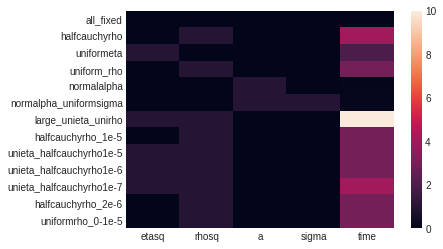

In [179]:
computetime = {'all_fixed':[0,0,0,0,.05],'halfcauchyrho':[0,1,0,0,4],'uniformeta':[1,0,0,0,2],
               'uniform_rho':[0,1,0,0,3],'normalalpha':[0,0,1,0,.1],
               'normalpha_uniformsigma':[0,0,1,1,.15],'large_unieta_unirho':[1,1,0,0,10.],
              'halfcauchyrho_1e-5':[0,1,0,0,3.],'unieta_halfcauchyrho1e-5':[1,1,0,0,3],
              'unieta_halfcauchyrho1e-6':[1,1,0,0,3],'unieta_halfcauchyrho1e-7':[1,1,0,0,4],
              'halfcauchyrho_2e-6':[0,1,0,0,3.],'uniformrho_0-1e-5':[0,1,0,0,3.],
              'covsigma0.5' : [1,1,1,1,2]}
                    
                             
comptime = pd.DataFrame.from_dict(computetime, orient='index',
   columns=['etasq','rhosq','a','sigma','time'])

sns.heatmap(comptime);

In [97]:

# ===== reparam ====

with pm.Model() as GP_reparam:
    
    """ 
    Trying to model two levels of a hierarchy, similar to a bayesian hierarchical model, 
    except, using a Gaussian Process to shrink the lower level estimates to the mean of the 
    higher level group. That way I do not have to define discrete groups that each farm belong to, 
    but can share information from farm to farm based on how close it is to other farms.
    This measure of similarity is given by the kernel function which defines a covariance matrix
    for the Gaussian Process. The trick is inserting my linear submodel.
    """
    
    # prior intercept
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained unique to each farm
    b = pm.Normal('b', 0, .5, shape=Num_farms) # slope to be trained unique to each farm
    # ========== Linear Model =============== 
    u = a[zero_farm_idx]  + b[zero_farm_idx]*df.zprsum3 
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    y = pm.Normal('NDVI', mu=u, sd=sigma, observed=df.zNDVIsum3)
    

    # ========== gaussian process ===========
    #kernel hyperparameter lengthscale
    ls = pm.HalfCauchy('l', .5) 
    #kernel
    cov = pm.gp.cov.ExpQuad(1,ls)
    gp = pm.gp.MarginalSparse(cov_func=cov)
    
    # slope for the individual farms, need y to be output from y above
    w = gp.marginal_likelihood('w', X=df_unique.Latitude[:,None],
                               Xu=df_unique.Latitude[:,None][::10],
                               y=df_unique.Bp_zprsum3 ,noise=.5)
    
 

    trace = pm.sample(500,tune=100)
    #mp = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [l, sigma, b, a]
Sampling 4 chains: 100%|██████████| 2400/2400 [01:31<00:00, 26.21draws/s]
The acceptance probability does not match the target. It is 0.9246911864651756, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9201357310152751, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292840252700125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9206587712401142, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2df780e48>,
      dtype=object)

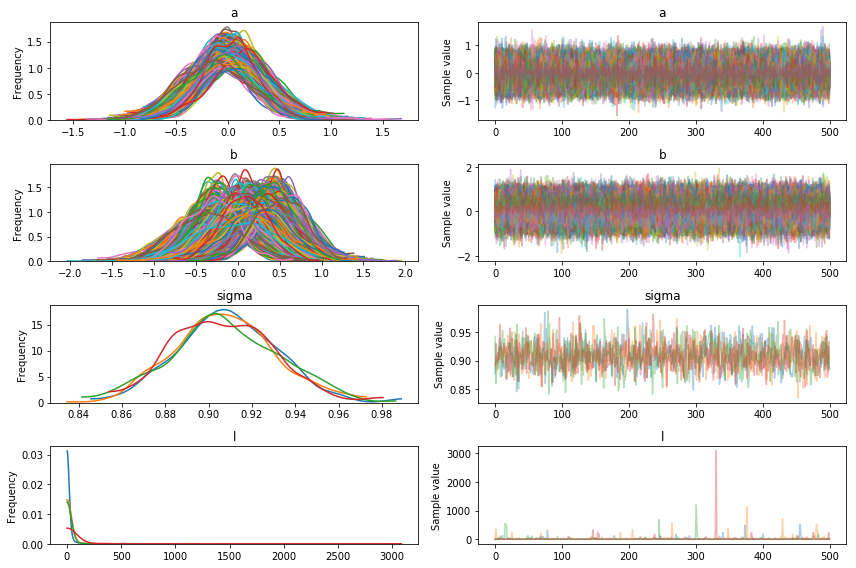

In [98]:
pm.traceplot(trace)

In [101]:
# add the GP conditional to the model, given the new X values
X_new = np.linspace(40,50,100)[:,None]#np.linspace(40,50,100)[:,None]
#with GP_reparam:
#    f_pred = gp.conditional("f_pred", X_new)
    
with GP_reparam:
    fs =  gp.conditional('fss', X_new)
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with GP_reparam:
    pred_samples = pm.sample_posterior_predictive([trace], vars=[fs], samples=2000)

AsTensorError: ('Cannot convert pixel\n60.0      Elemwise{true_div,no_inplace}.0\n317.0     Elemwise{true_div,no_inplace}.0\n327.0     Elemwise{true_div,no_inplace}.0\n396.0     Elemwise{true_div,no_inplace}.0\n437.0     Elemwise{true_div,no_inplace}.0\n445.0     Elemwise{true_div,no_inplace}.0\n510.0     Elemwise{true_div,no_inplace}.0\n524.0     Elemwise{true_div,no_inplace}.0\n550.0     Elemwise{true_div,no_inplace}.0\n570.0     Elemwise{true_div,no_inplace}.0\n698.0     Elemwise{true_div,no_inplace}.0\n738.0     Elemwise{true_div,no_inplace}.0\n768.0     Elemwise{true_div,no_inplace}.0\n785.0     Elemwise{true_div,no_inplace}.0\n910.0     Elemwise{true_div,no_inplace}.0\n993.0     Elemwise{true_div,no_inplace}.0\n1009.0    Elemwise{true_div,no_inplace}.0\n1265.0    Elemwise{true_div,no_inplace}.0\n1285.0    Elemwise{true_div,no_inplace}.0\n1303.0    Elemwise{true_div,no_inplace}.0\n1337.0    Elemwise{true_div,no_inplace}.0\n1352.0    Elemwise{true_div,no_inplace}.0\n1372.0    Elemwise{true_div,no_inplace}.0\n1392.0    Elemwise{true_div,no_inplace}.0\n1468.0    Elemwise{true_div,no_inplace}.0\n1475.0    Elemwise{true_div,no_inplace}.0\n1481.0    Elemwise{true_div,no_inplace}.0\n1495.0    Elemwise{true_div,no_inplace}.0\n1502.0    Elemwise{true_div,no_inplace}.0\n1604.0    Elemwise{true_div,no_inplace}.0\n                       ...               \n8179.0    Elemwise{true_div,no_inplace}.0\n8422.0    Elemwise{true_div,no_inplace}.0\n8516.0    Elemwise{true_div,no_inplace}.0\n8543.0    Elemwise{true_div,no_inplace}.0\n8576.0    Elemwise{true_div,no_inplace}.0\n8642.0    Elemwise{true_div,no_inplace}.0\n8644.0    Elemwise{true_div,no_inplace}.0\n8700.0    Elemwise{true_div,no_inplace}.0\n8767.0    Elemwise{true_div,no_inplace}.0\n8786.0    Elemwise{true_div,no_inplace}.0\n8791.0    Elemwise{true_div,no_inplace}.0\n8803.0    Elemwise{true_div,no_inplace}.0\n8841.0    Elemwise{true_div,no_inplace}.0\n8851.0    Elemwise{true_div,no_inplace}.0\n8877.0    Elemwise{true_div,no_inplace}.0\n8878.0    Elemwise{true_div,no_inplace}.0\n8889.0    Elemwise{true_div,no_inplace}.0\n8979.0    Elemwise{true_div,no_inplace}.0\n8981.0    Elemwise{true_div,no_inplace}.0\n9159.0    Elemwise{true_div,no_inplace}.0\n9261.0    Elemwise{true_div,no_inplace}.0\n9401.0    Elemwise{true_div,no_inplace}.0\n9406.0    Elemwise{true_div,no_inplace}.0\n9434.0    Elemwise{true_div,no_inplace}.0\n9717.0    Elemwise{true_div,no_inplace}.0\n9741.0    Elemwise{true_div,no_inplace}.0\n9801.0    Elemwise{true_div,no_inplace}.0\n9857.0    Elemwise{true_div,no_inplace}.0\n9860.0    Elemwise{true_div,no_inplace}.0\n9978.0    Elemwise{true_div,no_inplace}.0\nName: Bp_zprsum3, Length: 164, dtype: object to TensorType', <class 'pandas.core.series.Series'>)

In [ ]:
with pm.Model() as m_13_7_reparam:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq * pm.gp.cov.ExpQuad(2,ls=rhosq)
    
    g = pm.gp.MarginalSparse('g',cov_func=Kij)

    # priors
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    # linear model
    lam = pm.math.exp(a + g[dk.society.values] + bp * dk.logpop)
    # likelihood
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    # marginal likelihood
    g = gp.marginal_likelihood('g', X=X,y=y ,noise=.5)
    # inference
    trace_13_7_reparam = pm.sample(1000, tune=1000)

In [83]:
# ===== reparam vs. of mine ====
with pm.Model() as GP_reparam:
    

    # ========== gaussian process ===========
    #kernel hyperparameter lengthscale
    l = pm.HalfCauchy('l', 1) 
    #kernel
    cov = pm.gp.cov.ExpQuad(1,l)
    gp = pm.gp.MarginalSparse(cov_func=cov)
    # prior intercept
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained

    # ========== Linear Model =============== 
    u = a[zero_farm_idx]  + gp[zero_farm_idx]*df.zprsum3 
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    y = pm.Normal('NDVI', mu=u, sd=sigma, observed=df.zNDVIsum3)
    
    w = gp.marginal_likelihood('w', X=df_unique.Latitude[:,None],y=y ,noise=.5)
    
 

    #trace = pm.sample(500,tune=100)
    mp = pm.find_MAP()

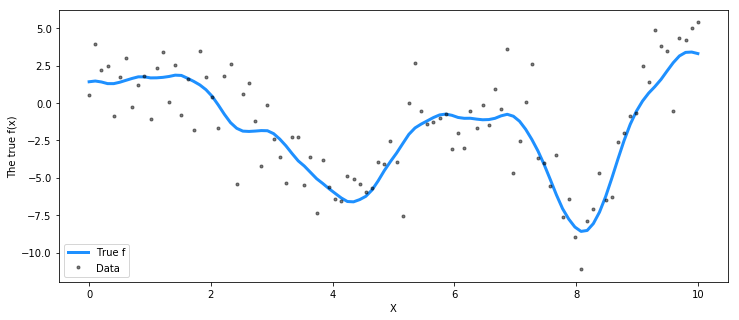

In [60]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

In [62]:
y.shape,X.shape

((100,), (100, 1))